In [81]:
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import sklearn
from sklearn.cluster import KMeans
import cv2
import numpy as np
import PIL
from PIL import Image, ImageChops, ImageDraw
from IPython.display import display
from skimage import io, img_as_float

# Step 1
Load data

In [82]:
with uproot.open('toyForStudents_5.root') as datafile:
    data_df = datafile['R0Tree'].arrays(library='pd')

# Step 2
First data look

In [83]:
df = pd.DataFrame(data_df)
df

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [84]:
df_id_minus_1 = df[df['id'] == -1]
df_id_1 = df[df['id'] == 1]

In [85]:
df_id_minus_1

,x,y,id,sample
1700000,3.524324,2.084737,-1,1
1700001,3.497870,1.261757,-1,1
1700002,2.418601,1.440717,-1,1
1700003,3.495933,1.956262,-1,1
1700004,2.284854,2.110827,-1,1
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [86]:
df_id_1

,x,y,id,sample
0,3.460569,0.673391,1,1
1,3.075171,0.761314,1,1
2,2.746258,1.339751,1,1
3,2.190463,2.049242,1,1
4,3.988466,0.707543,1,1
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [87]:
def print_images():
    grouped_minus_1 = df_id_minus_1.groupby('sample')
    grouped_1 = df_id_1.groupby('sample')

    for sample, group_minus_1 in grouped_minus_1:
        group_1 = grouped_1.get_group(sample)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # DLA id = -1
        axs[0].scatter(group_minus_1['x'], group_minus_1['y'], label='id = -1', color='blue', marker=',', s=1)
        axs[0].set_title(f'Obrazek dla sample {sample} (id = -1)')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('y')
        axs[0].legend()

        # DLA id = 1
        axs[1].scatter(group_1['x'], group_1['y'], label='id = 1', color='red', marker=",", s=1)
        axs[1].set_title(f'Obrazek dla sample {sample} (id = 1)')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('y')
        axs[1].legend()

        plt.tight_layout()
        plt.show()


# Step 3
Plots, interpolated

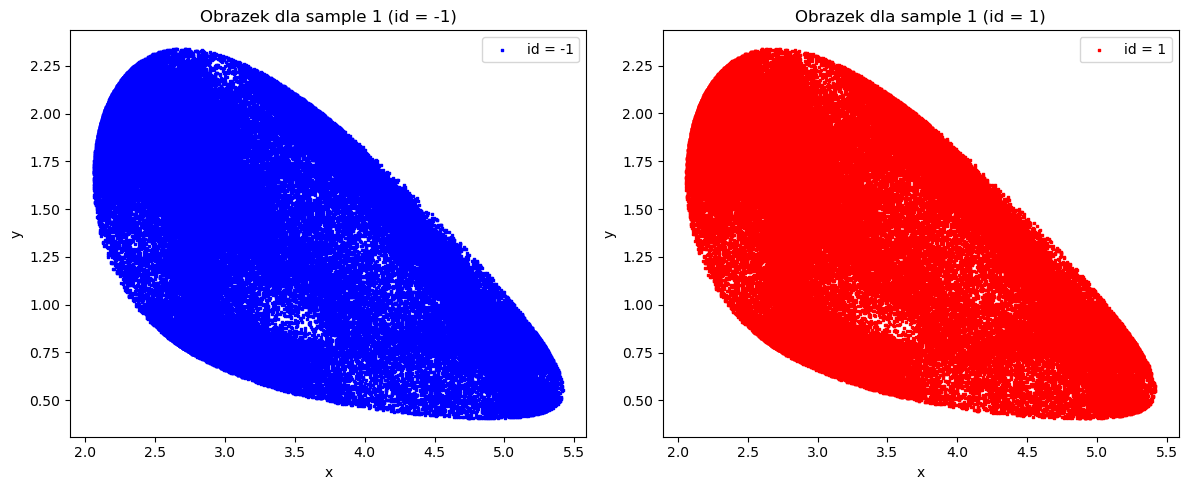

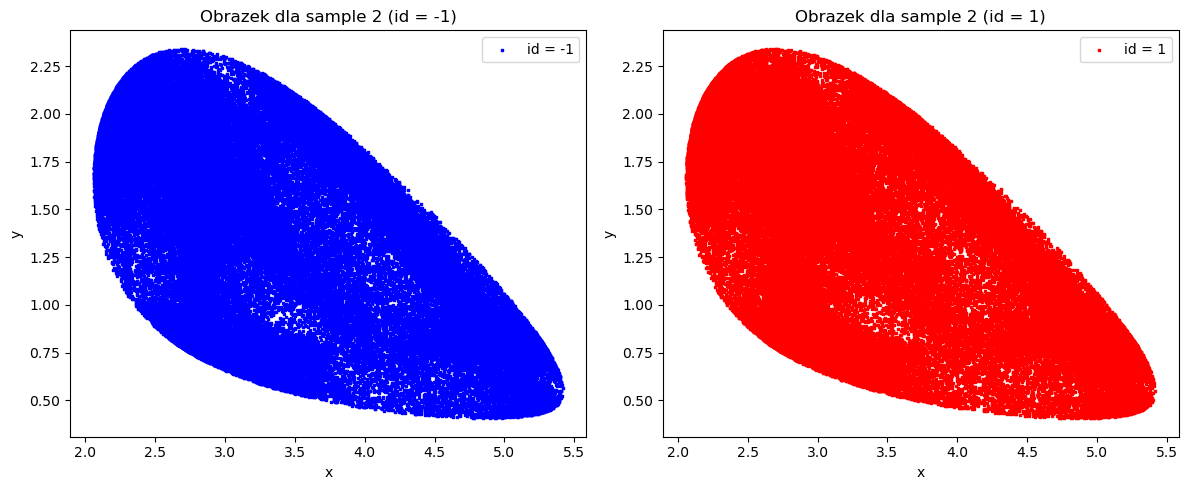

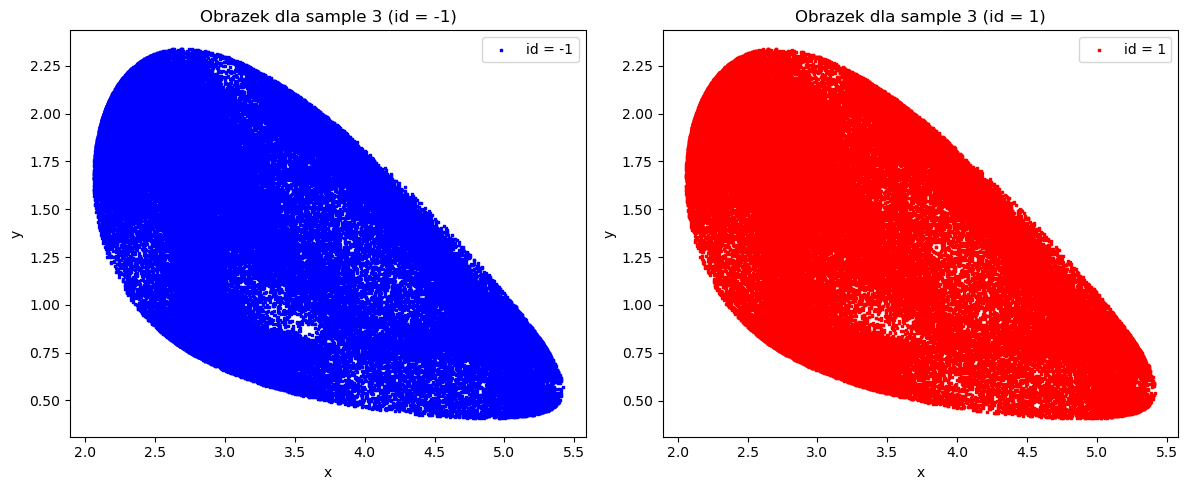

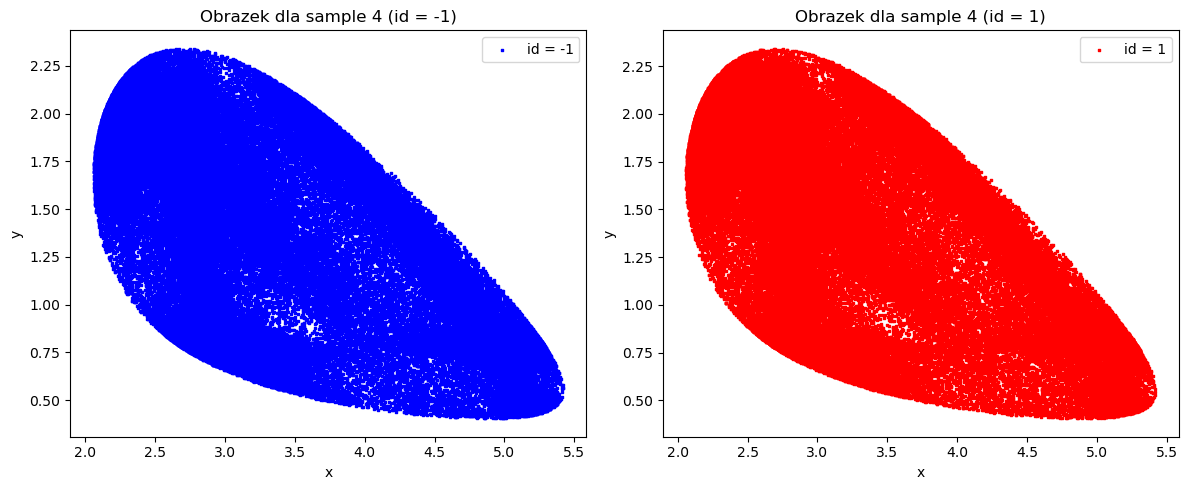

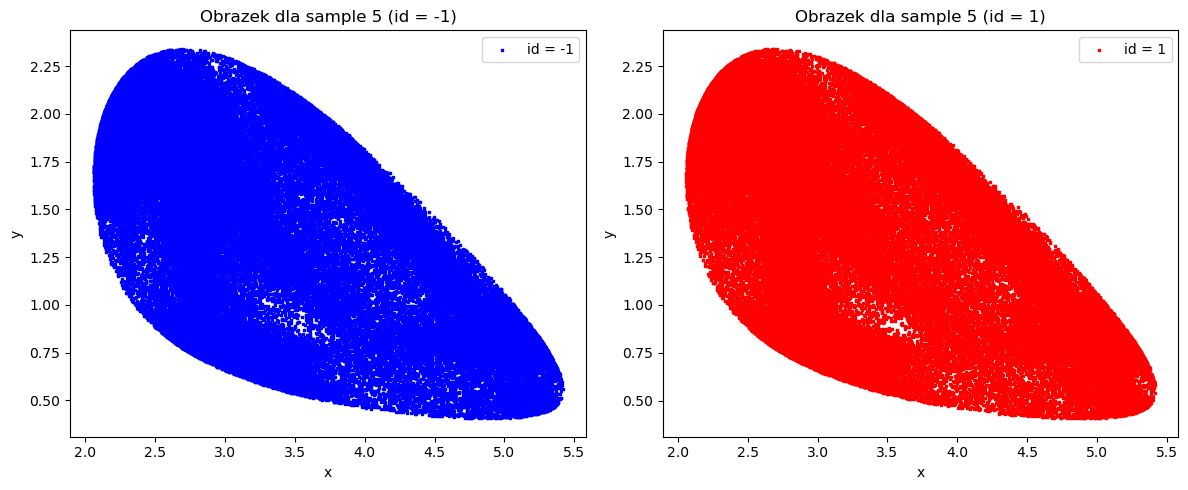

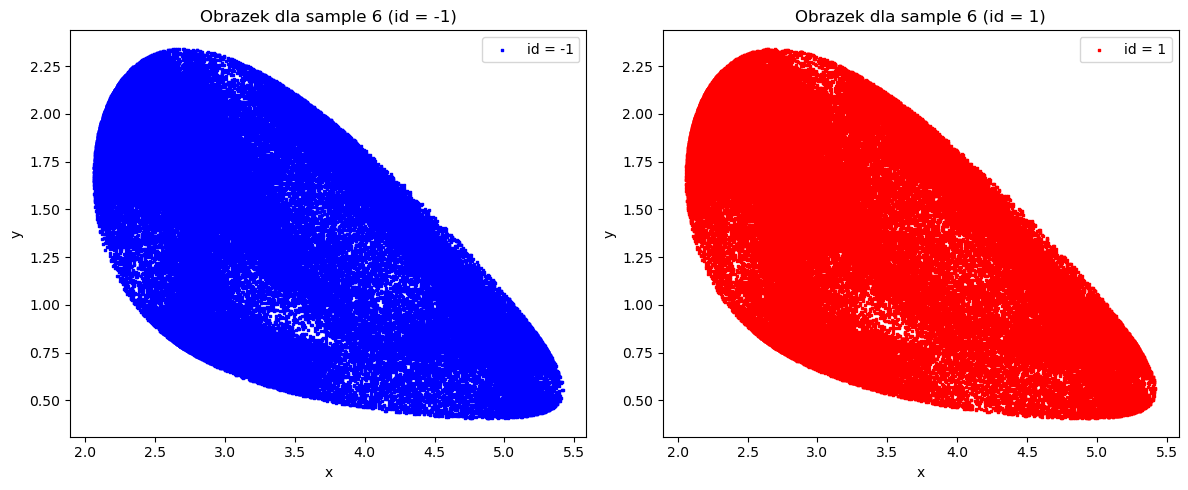

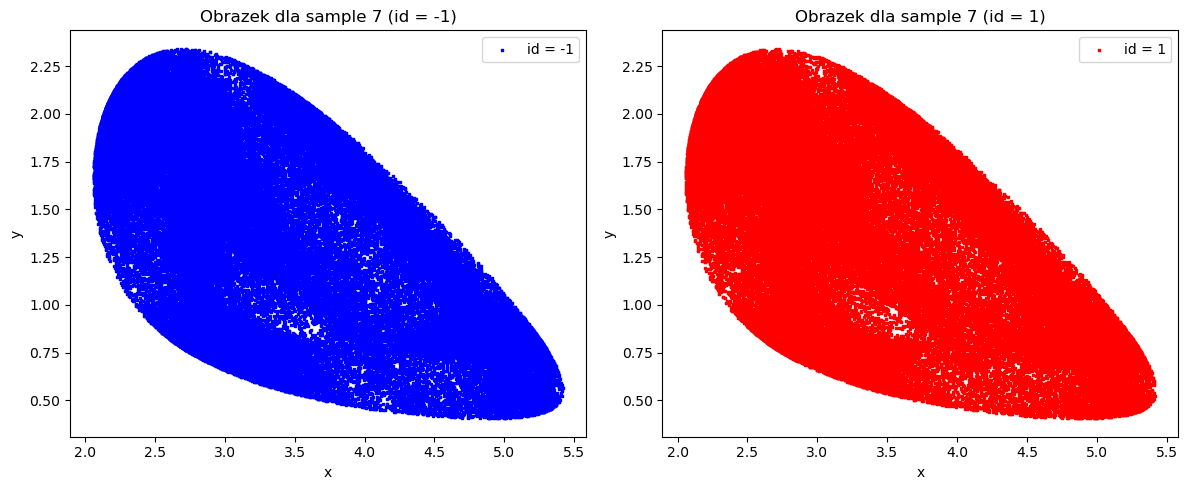

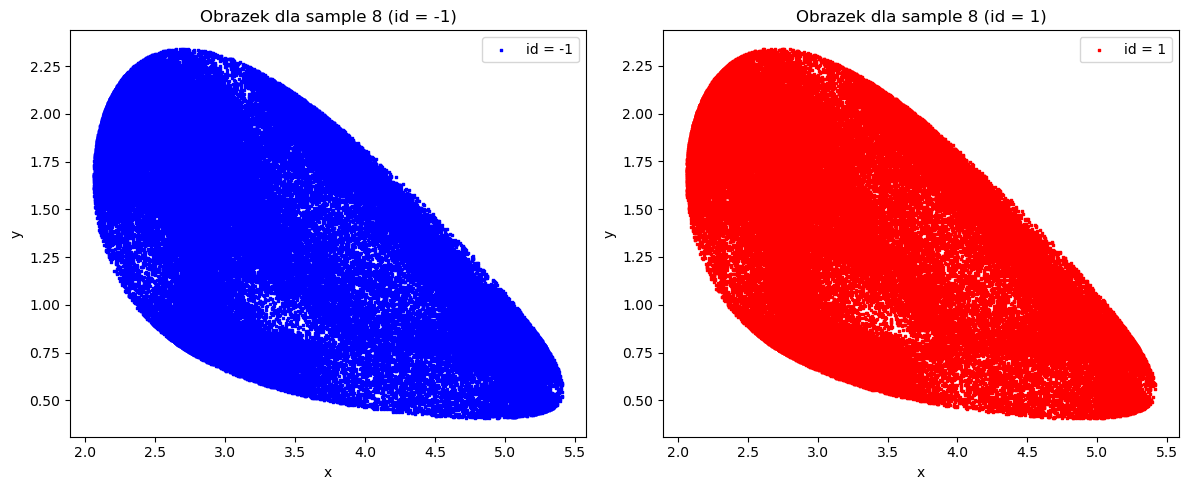

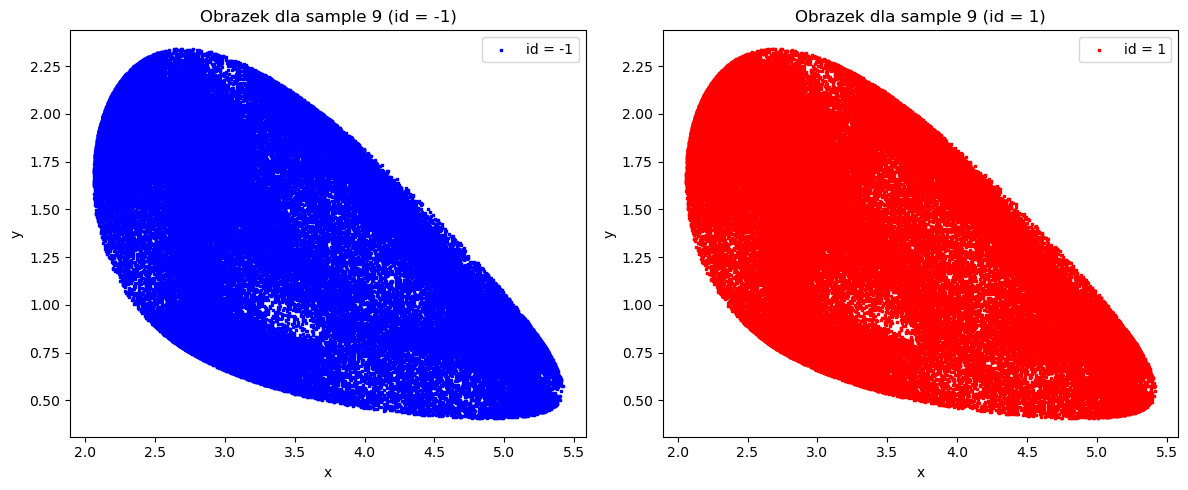

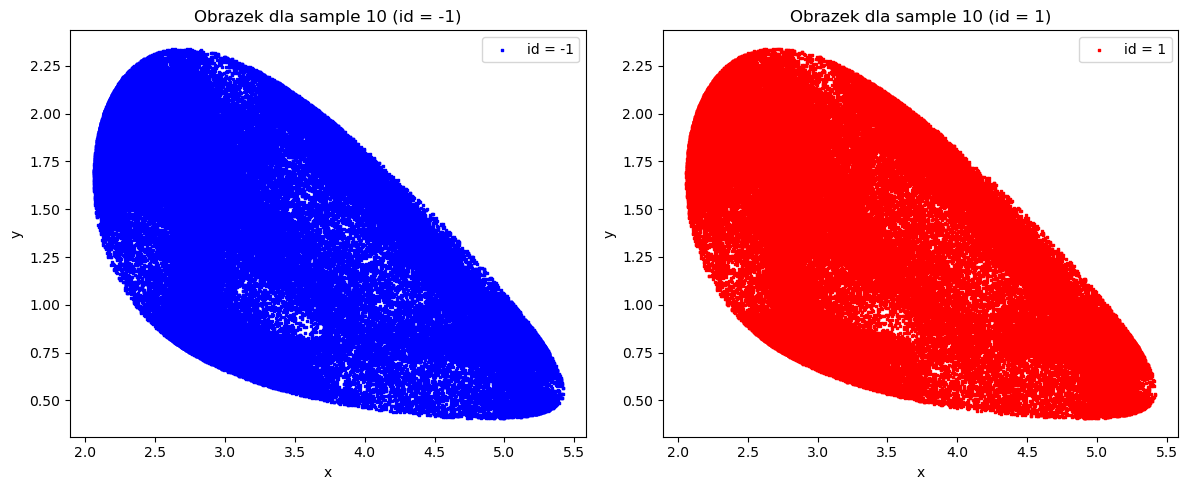

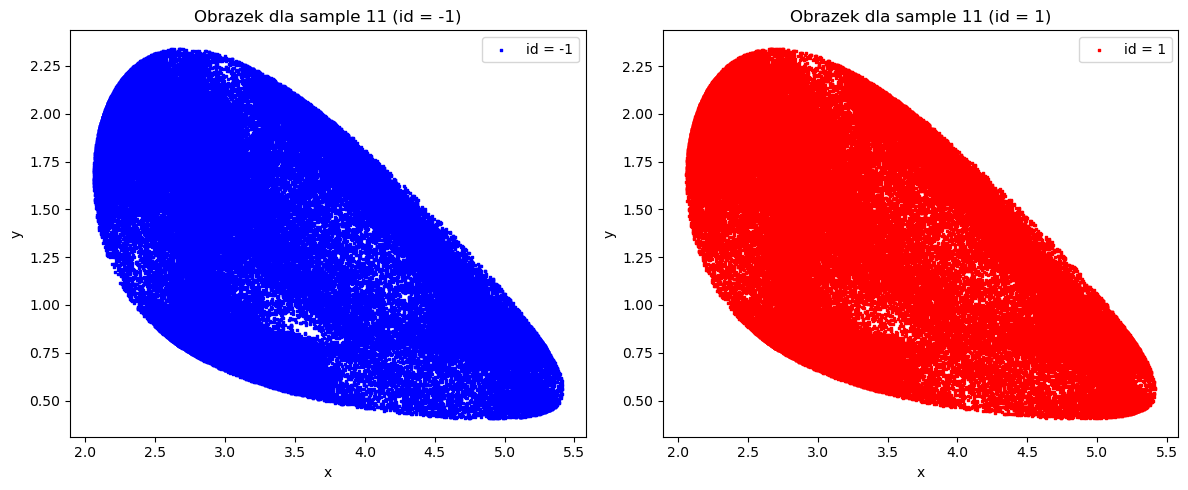

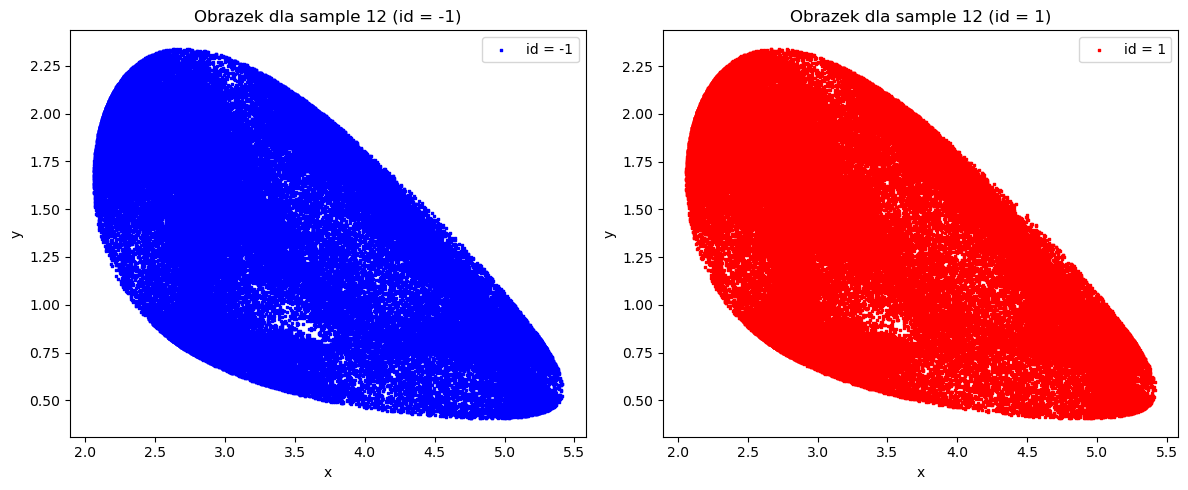

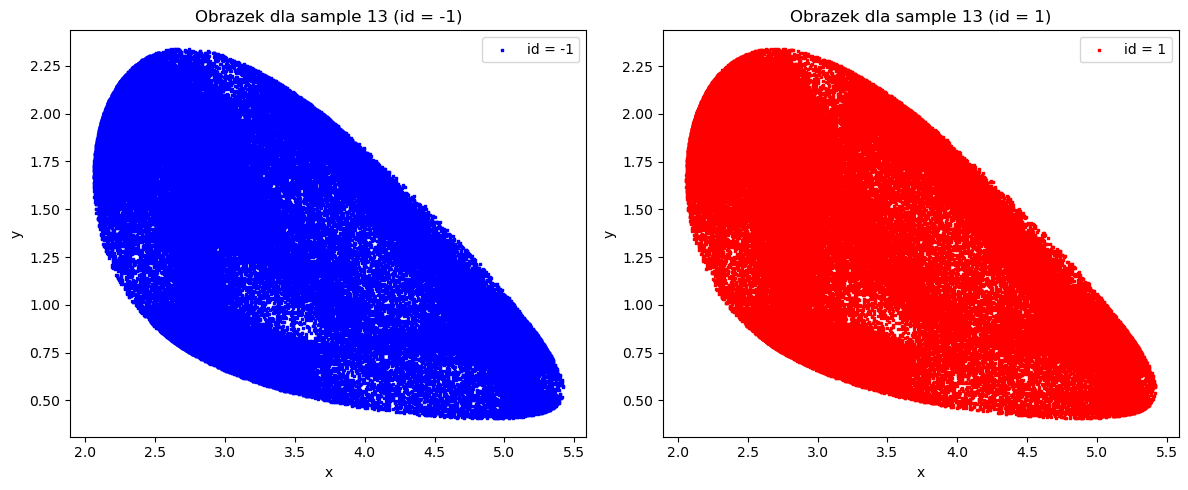

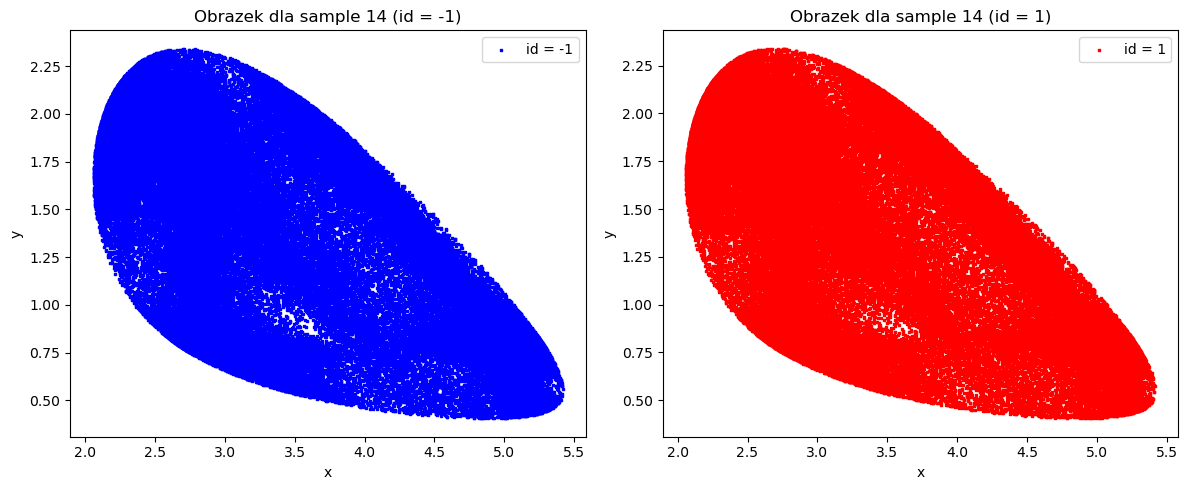

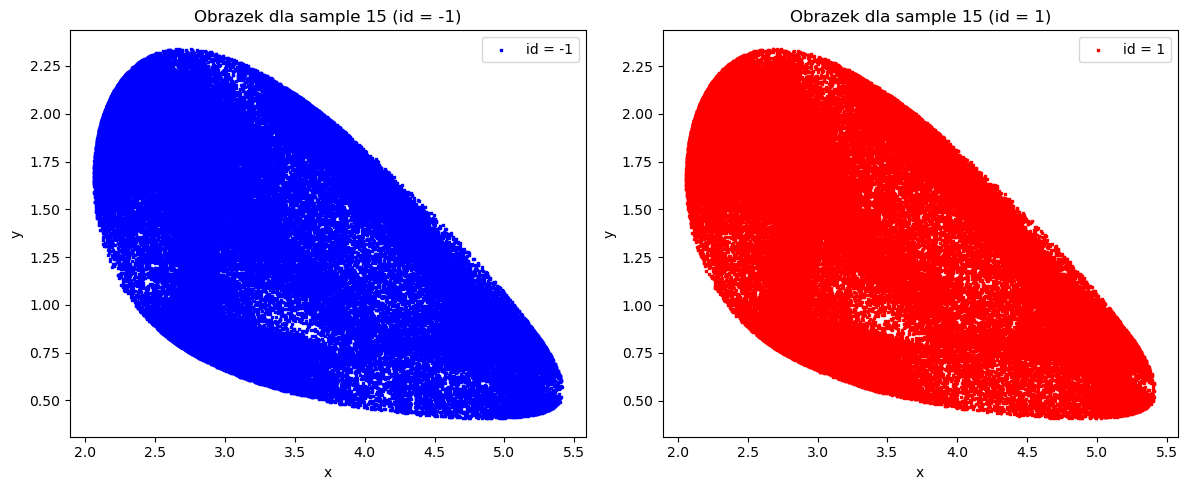

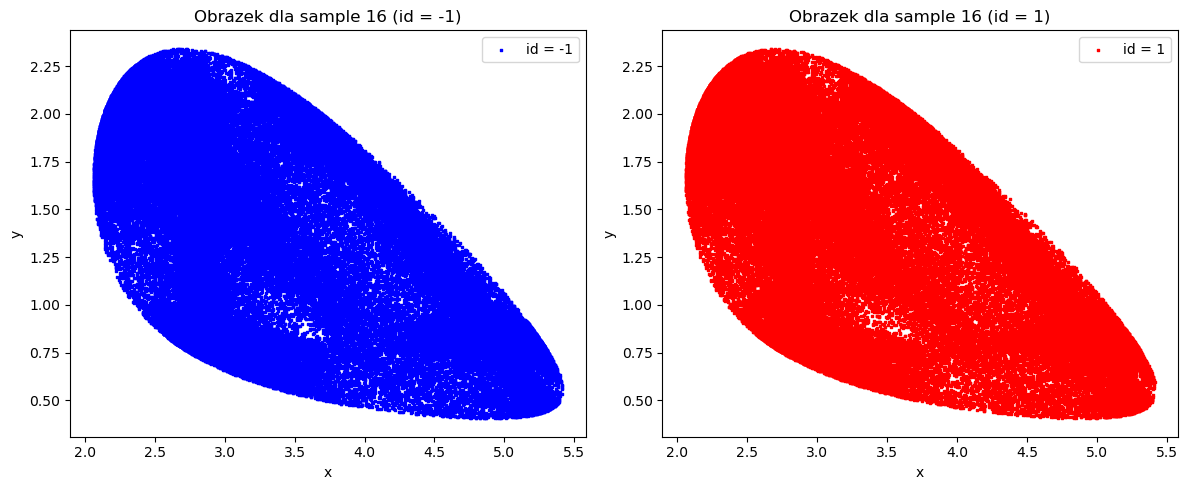

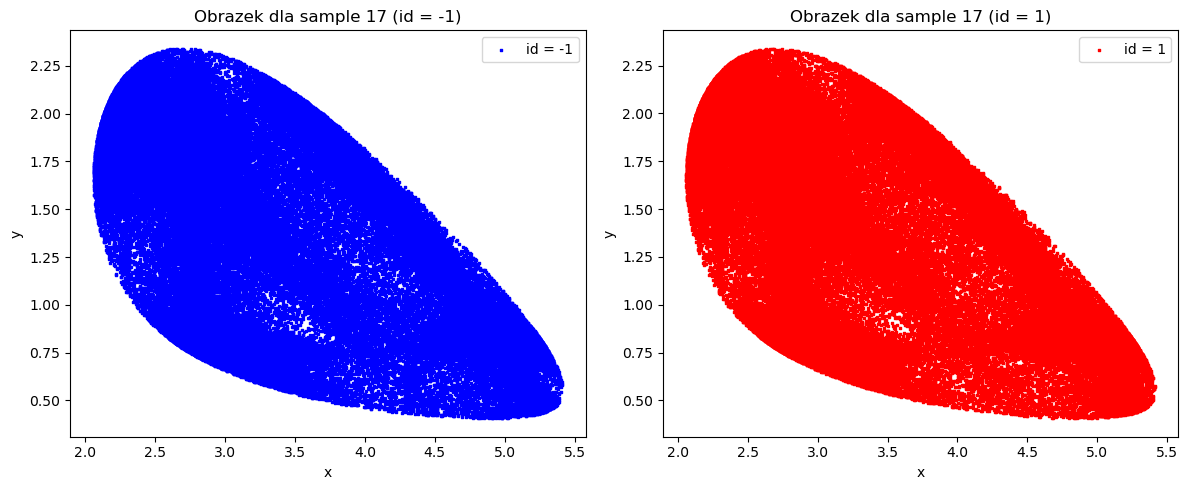

In [88]:
print_images()

# Step 4
Save cloud points as png files to get exact images

In [89]:
def get_model_training_images(sample):
    data_id_minus_1 = df_id_minus_1[(df_id_minus_1['sample'] == sample) & (df_id_minus_1['id'] == -1)]
    data_id_1 = df_id_1[(df_id_1['sample'] == sample) & (df_id_1['id'] == 1)]

    return data_id_minus_1, data_id_1

In [90]:
a, b = get_model_training_images(17)

In [91]:
a

,x,y,id,sample
3300000,3.140368,2.036576,-1,17
3300001,3.498585,0.740953,-1,17
3300002,3.234064,1.930019,-1,17
3300003,2.658791,0.798944,-1,17
3300004,3.423107,2.123055,-1,17
...,...,...,...,...
3399995,3.656641,0.730766,-1,17
3399996,5.113425,0.666245,-1,17
3399997,2.826508,1.441562,-1,17
3399998,3.683099,1.125471,-1,17


In [92]:
b

,x,y,id,sample
1600000,4.465685,0.796268,1,17
1600001,4.763283,0.922533,1,17
1600002,2.679387,1.167562,1,17
1600003,3.276646,1.320163,1,17
1600004,3.004393,1.491962,1,17
...,...,...,...,...
1699995,2.924093,1.452403,1,17
1699996,2.067248,1.737031,1,17
1699997,2.581711,1.004430,1,17
1699998,4.302710,1.388870,1,17


In [97]:
# def save_point_cloud_as_image(dataframe, filename):
#     width = 500
#     height = 500

#     min_x = dataframe['x'].min()
#     max_x = dataframe['x'].max()
#     min_y = dataframe['y'].min()
#     max_y = dataframe['y'].max()

#     image = Image.new("RGB", (width, height), "white")
#     draw = ImageDraw.Draw(image)

#     for _, row in dataframe.iterrows():
#         x = int((row['x'] - min_x) / (max_x - min_x) * width)
#         y = int((row['y'] - min_y) / (max_y - min_y) * height)
#         draw.point((x, y), fill="black")

#     image.save(filename)

def save_point_cloud_as_image(dataframe, filename):
    width = 600
    height = 600
    padding = 5

    min_x = dataframe['x'].min()
    max_x = dataframe['x'].max()
    min_y = dataframe['y'].min()
    max_y = dataframe['y'].max()
    
    x_scale = (width - 2 * padding) / (max_x - min_x)
    y_scale = (height - 2 * padding) / (max_y - min_y)

    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)

    for _, row in dataframe.iterrows():
        x = int((row['x'] - min_x) * x_scale) + padding
        y = int((row['y'] - min_y) * y_scale) + padding
        draw.point((x, height - y - 1), fill="black")  # Invert y to match image coordinates

    image.save(filename)


In [98]:
for i in range(1, 18, 1):
    print(f"========== SAMPLE {i} ==========")
    img_minus, img = get_model_training_images(i)
    save_point_cloud_as_image(img_minus, f"cloud_points_to_images_minus/img_minus_{i}.png")
    save_point_cloud_as_image(img, f"cloud_points_to_images/img_{i}.png")
    print(f"Sample {i} saved to cloud_points_to_images/ folder.")
print(f"================================")
print("Conversion done.")

========== SAMPLE 1 ==========
Sample 1 saved to cloud_points_to_images/ folder.
========== SAMPLE 2 ==========
Sample 2 saved to cloud_points_to_images/ folder.
========== SAMPLE 3 ==========
Sample 3 saved to cloud_points_to_images/ folder.
========== SAMPLE 4 ==========
Sample 4 saved to cloud_points_to_images/ folder.
========== SAMPLE 5 ==========
Sample 5 saved to cloud_points_to_images/ folder.
========== SAMPLE 6 ==========
Sample 6 saved to cloud_points_to_images/ folder.
========== SAMPLE 7 ==========
Sample 7 saved to cloud_points_to_images/ folder.
========== SAMPLE 8 ==========
Sample 8 saved to cloud_points_to_images/ folder.
========== SAMPLE 9 ==========
Sample 9 saved to cloud_points_to_images/ folder.
========== SAMPLE 10 ==========
Sample 10 saved to cloud_points_to_images/ folder.
========== SAMPLE 11 ==========
Sample 11 saved to cloud_points_to_images/ folder.
========== SAMPLE 12 ==========
Sample 12 saved to cloud_points_to_images/ folder.
========== SAMPLE 13 =

# Step 5
Cluster analysis
https://scikit-learn.org/stable/modules/clustering.html

## PIL library

In [ ]:
def PIL_diff(img1, img2):
    diff = ImageChops.difference(img1, img2)
    if diff.getbbox():
        # yellow_bg = Image.new("RGB", diff.size, "yellow")
        # result = ImageChops.add(yellow_bg, diff)
        # display(result)
        display(diff)
    else:
        print("No differences")

In [ ]:
def load_image_from_folder(folder, filename):
    path = f"{folder}/{filename}"
    return Image.open(path)

img_minus_1_loaded = load_image_from_folder("cloud_points_to_images_minus", "img_minus_1.png")
img_1_loaded = load_image_from_folder("cloud_points_to_images", "img_1.png")

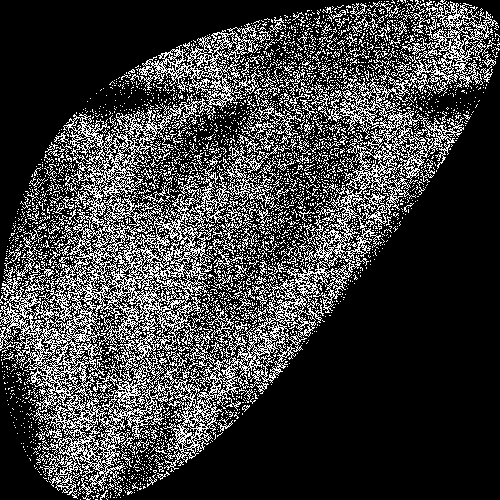

In [ ]:
PIL_diff(img_minus_1_loaded, img_1_loaded)

## K-Means

In [ ]:
# def detect_image_differences(img1, img2, num_clusters=8):
#     img1_array = img_as_float(img1)
#     img2_array = img_as_float(img2)
#
#     img1_flat = img1_array.reshape((-1, 3))
#     img2_flat = img2_array.reshape((-1, 3))
#
#     kmeans1 = KMeans(n_clusters=num_clusters, random_state=42)
#     kmeans2 = KMeans(n_clusters=num_clusters, random_state=42)
#     labels1 = kmeans1.fit_predict(img1_flat)
#     labels2 = kmeans2.fit_predict(img2_flat)
#
#     differences = labels1 != labels2
#
#     differences_img = differences.reshape(img1_array.shape[:2])
#
#     return differences_img

In [ ]:
def detect_image_differences(img1, img2, max_clusters=10):
    # Konwertowanie obrazów na macierze numpy
    img1_array = img_as_float(img1)
    img2_array = img_as_float(img2)

    # Przekształcenie obrazów na przestrzeń RGB (płaska macierz)
    img1_flat = img1_array.reshape((-1, 3))
    img2_flat = img2_array.reshape((-1, 3))

    # Inicjalizacja listy przechowującej wartości sumy kwadratów odległości dla różnej liczby klastrów
    distortions = []

    # Obliczenie sumy kwadratów odległości dla różnej liczby klastrów
    for num_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(img1_flat)
        distortions.append(kmeans.inertia_)

    # Wykres metody łokcia
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

    # Wybór liczby klastrów na podstawie metody łokcia (można również ustawić ręcznie)
    num_clusters = 2  # Ustaw ręcznie lub użyj automatycznego wyboru
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels1 = kmeans.fit_predict(img1_flat)
    labels2 = kmeans.predict(img2_flat)

    # Porównanie etykiet pikseli między obrazami
    differences = labels1 != labels2

    # Konwersja różnic z powrotem na wymiary obrazu
    differences_img = differences.reshape(img1_array.shape[:2])

    return differences_img

c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mic

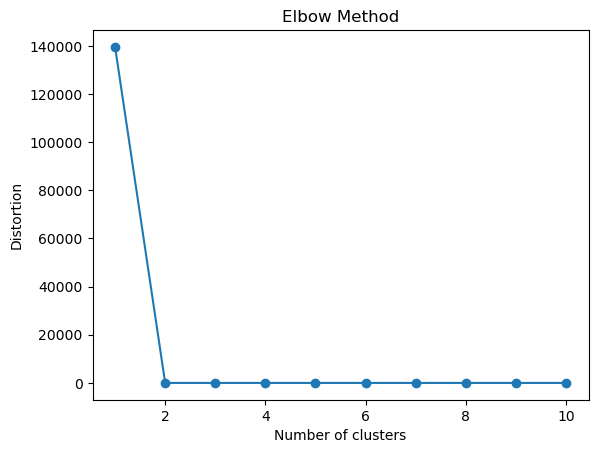

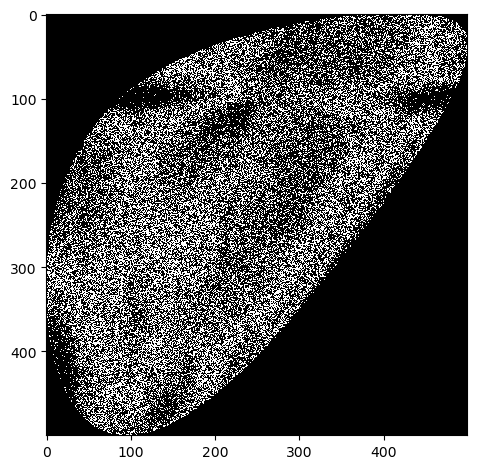

In [ ]:
differences_img = detect_image_differences(img_minus_1_loaded, img_1_loaded)

io.imshow(differences_img, cmap='gray')
io.show()

c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\micha\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\mic

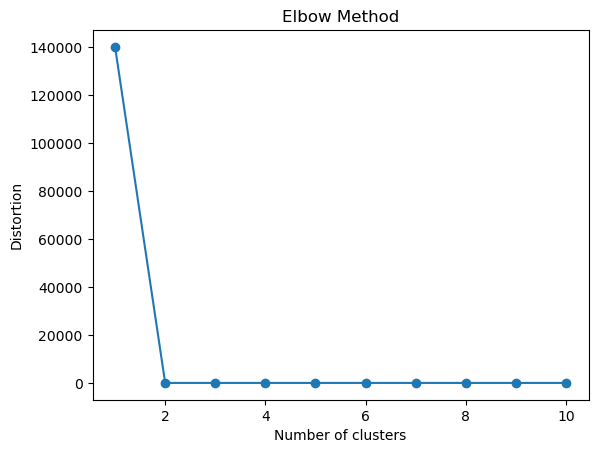

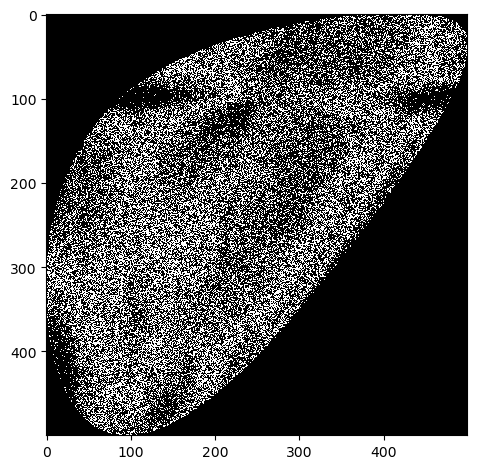

In [ ]:
differences_img = detect_image_differences(img_1_loaded, img_minus_1_loaded)

io.imshow(differences_img, cmap='gray')
io.show()

In [101]:
import pandas as pd

# Define the x and y coordinates for 10 points
x_coordinates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 15, 25, 35]
y_coordinates = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 15, 25, 35]

# Create a DataFrame with id and sample equal to 1
df1 = pd.DataFrame({
    'x': x_coordinates,
    'y': y_coordinates,
    'id': 1,
    'sample': 1
})

x_coordinates = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 55, 65, 75]
y_coordinates = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 55, 65, 75]

# Create a DataFrame with id and sample equal to -1
df2 = pd.DataFrame({
    'x': x_coordinates,
    'y': y_coordinates,
    'id': -1,
    'sample': -1
})

# Concatenate the two DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# Print the concatenated DataFrame
#df

In [102]:
df_id_minus_1_test = df[df['id'] == -1]
df_id_1_test = df[df['id'] == 1]


In [103]:
def print_images2():
  
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # DLA id = -1
    axs[0].scatter(df_id_minus_1_test['x'], df_id_minus_1_test['y'], label='id = -1', color='blue', marker=',', s=1)
    axs[0].set_title(f'Obrazek dla sample (id = -1)')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].legend()

    # DLA id = 1
    axs[1].scatter(df_id_1_test['x'], df_id_1_test['y'], label='id = 1', color='red', marker=",", s=1)
    axs[1].set_title(f'Obrazek dla sample (id = 1)')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].legend()

    plt.tight_layout()
    plt.show()


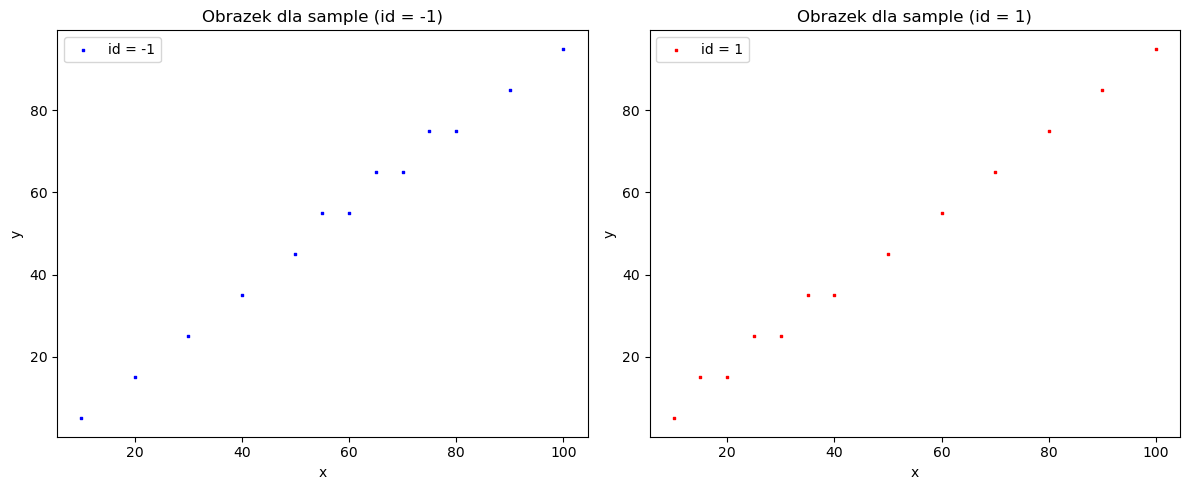

In [104]:
print_images2()

In [105]:
def get_model_training_images():
    data_id_minus_1 = df_id_minus_1_test[(df_id_minus_1_test['sample']) & (df_id_minus_1_test['id'] == -1)]
    data_id_1 = df_id_1_test[(df_id_1_test['sample']) & (df_id_1_test['id'] == 1)]

    return data_id_minus_1, data_id_1

img_minus, img = get_model_training_images()
save_point_cloud_as_image(img_minus, f"test/img_minus_1.png")
save_point_cloud_as_image(img, f"test/img_1.png")
print(f"================================")
print("Conversion done.")


save_point_cloud_as_image(img_minus, f"test/img_minus_1.png")
save_point_cloud_as_image(img, f"test/img_1.png")


Conversion done.


In [106]:
img_test_minus_1 = load_image_from_folder("test", "img_minus_1.png")
img_test_1 = load_image_from_folder("test", "img_1.png")

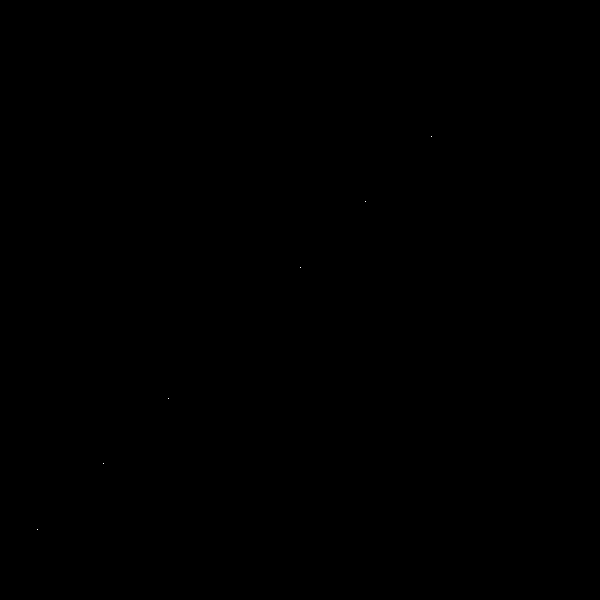

In [108]:
PIL_diff(img_test_minus_1, img_test_1)